# <font color='darkorange'>Loading and splitting the dataset </font>

In [2]:
df = pd.read_csv('data/processed_data_train.csv')
df['WORDING'] = df['WORDING'].astype('str') #change nan to 'nan'

In [3]:
train, test = train_test_split(df, test_size=0.375, random_state=42)

In [4]:
X_train=train.drop(['PREMIUM','FACUL_NUM'],axis=1)
y_train=train[['PREMIUM']]

X_test=test.drop(['PREMIUM','FACUL_NUM'],axis=1)
y_test=test[['PREMIUM']]

This part is used for the last prediction of our submission file

In [3]:
# train = pd.read_csv('data/processed_data_train.csv')
# train['WORDING'] = train['WORDING'].astype('str')
# test = pd.read_csv('data/processed_data_test.csv')
# test['WORDING'] = test['WORDING'].astype('str')

# X_train=train.drop(['PREMIUM','FACUL_NUM'],axis=1)
# y_train=train[['PREMIUM']]
# X_test=test.drop(['FACUL_NUM'],axis=1)
# X_test['FXRATEUSD'] = X_test['FXRATEUSD'].str.replace(",",'.').astype('float64')
# X_test.shape

(3259, 48)

# <font color='darkorange'> Data preparation and metrics </font>

In [4]:
numerical= ['CT_PERIOD', 'BI_PERIOD',
            'INSUREDVALUEPD', 'INSUREDVALUEBI',
           'NBLOCS', 'OIL', 'LIMIT', 'ATTACHMENT',
           'XXX_SHARE', 'MODELED_CAT_EXPLOSS', 'DISCOUNTS',
           'DEDUCTION', 'TXCHANGE', 'TOP_MPL',
           'TOP_FMLS', 'PD_price(M)', 'BI_time(Days)',
           'Both_price(M)', 'PD_percent_loss (%)',
           'UWYEAR_label', 'weighted_hazard', 'uw_index',
           'financial_ratio','COVER_BI', 'EXT_EXPENSE', 'FXRATEUSD', 'TOTALINSUREDVALUE']
categorical = X_train.drop(columns=numerical).columns

Here we transform all the numerical columns to a normal distribution

In [5]:
X_num_train = X_train[numerical]
X_num_test = X_test[numerical]

scaler = QuantileTransformer(output_distribution='normal')
X_num_norm_train = scaler.fit_transform(X_num_train)
X_num_norm_test = scaler.transform(X_num_test)

X_train[numerical] = X_num_norm_train
X_test[numerical] = X_num_norm_test

In [6]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]) 

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

In [9]:
def get_cv_rmse(clf, X_train, y_train):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}")

In [10]:
def get_test_rmse(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_head = clf.predict(X_test)
    print('R square Accuracy: ',r2_score(y_test,y_head))
    print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
    print('Root Mean Squared Error Accuracy: ', np.sqrt(mean_squared_error(y_test,y_head)))

In [16]:
def get_feature_importance(clf, X_train, y_train):
    feature_importances = permutation_importance(
        clf, X_train, y_train, n_repeats=10)
    sorted_idx = feature_importances.importances_mean.argsort()
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()

This part is used for the last prediction of our submission file

In [10]:
# xg_regressor = XGBRegressor(n_estimators=5000,max_depth=5,learning_rate=0.05)
# clf_xg = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('regressor' , xg_regressor)])
# clf_xg.fit(X_train, np.log(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['CT_PERIOD', 'BI_PERIOD',
                                                   'INSUREDVALUEPD',
                                                   'INSUREDVALUEBI', 'NBLOCS',
                                                   'OIL', 'LIMIT', 'ATTACHMENT',
                                                   'XXX_SHARE',
                                                   'MODELED_CAT_EXPLOSS',
                                                   'DISCOUNTS', 'DEDUCTION',
                                                   'TXCHANGE', 'TOP_MPL',
                                                   'TOP_FMLS', 'PD_price(M)',
                                                   'BI_time(Days)',
    

In [11]:
# y_pred = np.exp(clf_xg.predict(X_test))
# y_pred.shape

(3259,)

In [12]:
# pd.DataFrame(y_pred).to_excel('Submission.xlsx')

#### We will be focusing on tree-based model for a few reasons

- We have a mixed set of categorical and numerical data.
- Initial tests with AutoML suggest better performance of tree-based models. (Refer to the notebook '3-AutoML Testing')
- Tree-based models are easier to train compare to neural network and offers higher interpretability.
- The size of the data we have is more adaptable for tree-based model than neural network.

# <font color='darkorange'>Model 1.1- GradientBoosting Regressor(With all the features) </font>

Here all the features mean all those from preprocessed data set. During preprocess, we dropped some variables.
#### Training

In [14]:
gb_regressor = GradientBoostingRegressor(n_estimators=300, max_depth=5)
clf_gb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor' , gb_regressor)])

get_cv_rmse(clf_gb, X_train, y_train) #158056.0946 +/- 18221.4314

RMSE: 160990.2718 +/- 13719.7999


#### Testing

In [15]:
get_test_rmse(clf_gb, X_train, y_train, X_test, y_test) #167337.20879196902

R square Accuracy:  0.7603481109592676
Mean Absolute Error Accuracy:  63816.550469448135
Root Mean Squared Error Accuracy:  162455.5092276171


#### Feature importance

It's very interesting to take a look at feature importance for our model. We currently have a very large number of input features and it would be interesting to compare the models performances with different subsets of features.

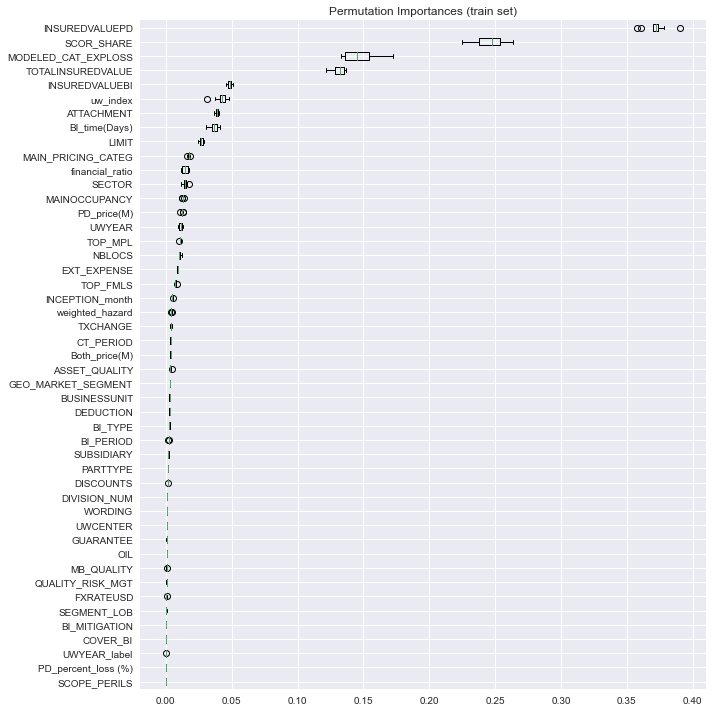

In [17]:
get_feature_importance(clf_gb, X_train, y_train)

# <font color='darkorange'>Model 1.2 - XGBoost Regressor (With all the features) </font>
XGBoost Regressor is a common ensemble regressor in machine learning problem. It ameliorates the radom forest algorithm and keeps the best structure of prediction trees. It's also a very efficient algorithm compared to the classic neural network.
#### Training

In [18]:
xg_regressor = XGBRegressor(n_estimators=5000,max_depth=5,learning_rate=0.05)
clf_xg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor' , xg_regressor)])
get_cv_rmse(clf_xg, X_train, y_train)

RMSE: 153410.2151 +/- 16199.6468


#### Testing

In [19]:
get_test_rmse(clf_xg, X_train, y_train, X_test, y_test)

R square Accuracy:  0.7673926098530917
Mean Absolute Error Accuracy:  61541.06947504151
Root Mean Squared Error Accuracy:  160050.03364380918


#### Feature Importance

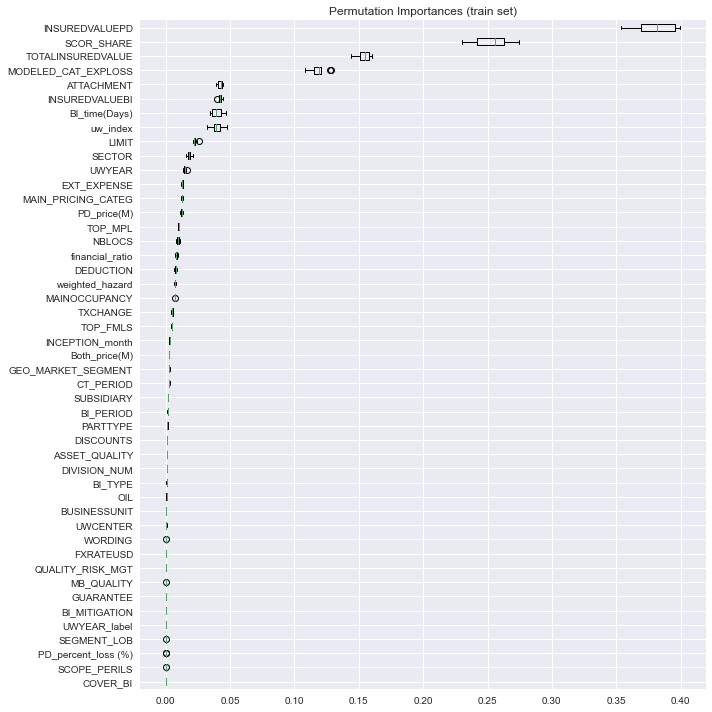

In [20]:
get_feature_importance(clf_xg, X_train, y_train)

# <font color='darkorange'>Model 1.3 - LightGBM Regressor (With all the features)</font>
Light Graident Boosting Machine (LGBM) is a popular tree-based algorthim for handling tabular data. Compare to other algothrims, it has the following advantages:

- Optimization in Speed and Memory Usage through histogram-based design 
- Optimization in accuracy through leaf-based growth 
- Optimization in handling categorical data

The disadvantage is:
- Leaf-wise growth may cause over-fitting when data is small


We perform a grid search for the best hyperparameters based on the guidelines at https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b and obatined the following model.
#### Training

In [21]:
lgbm_regressor=lgb.LGBMRegressor(feature_fraction=0.8, max_bin=100, max_depth=-1, min_data_in_leaf=5, num_leaves=128)
clf_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor' , lgbm_regressor)])

get_cv_rmse(clf_lgbm, X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min

#### Testing

In [22]:
get_test_rmse(clf_lgbm, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
R square Accuracy:  0.7402231508567836
Mean Absolute Error Accuracy:  64152.347104126544
Root Mean Squared Error Accuracy:  169139.18669309973


#### Feature Importance

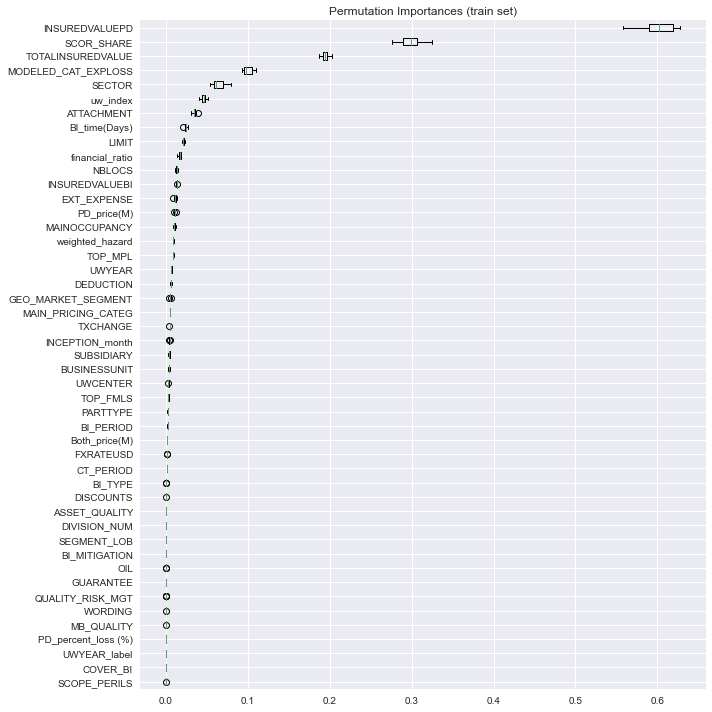

In [23]:
get_feature_importance(clf_lgbm, X_train, y_train)

# <font color='darkorange'>Model 2.1 - GradientBoosting Regressor(With the chosen features) </font>

The chosen feautures here are generated by the **Feauture Selection notebook**

#### Training

In [24]:
chosen_features = ['BI_PERIOD','BI_time(Days)','Both_price(M)','DEDUCTION', 'INSUREDVALUEBI',
                'INSUREDVALUEPD','LIMIT','MODELED_CAT_EXPLOSS','NBLOCS','OIL','PD_percent_loss (%)',
                 'PD_price(M)','XXX_SHARE','TOP_MPL','TXCHANGE','financial_ratio','uw_index','weighted_hazard',
                   
                'BI_TYPE','BUSINESSUNIT','COVER_BI','DIVISION_NUM','GEO_MARKET_SEGMENT','INCEPTION_month',
                   'MAINOCCUPANCY','MAIN_PRICING_CATEG','SCOPE_PERILS','SECTOR','SEGMENT_LOB','SUBSIDIARY',
                 'UWCENTER','UWYEAR']

In [25]:
X_train_select = X_train[chosen_features]
X_test_select = X_test[chosen_features]

We redefine the numerical columns and the categorical columns. Note that all the numerical values here have already been transformed into normal distribution in the previous part, so we don't need to do it again

In [26]:
numerical= ['BI_PERIOD','BI_time(Days)','Both_price(M)','DEDUCTION', 'INSUREDVALUEBI',
                'INSUREDVALUEPD','LIMIT','MODELED_CAT_EXPLOSS','NBLOCS','OIL','PD_percent_loss (%)',
                 'PD_price(M)','XXX_SHARE','TOP_MPL','TXCHANGE','financial_ratio','uw_index','weighted_hazard']
categorical = X_train_select.drop(columns=numerical).columns

In [27]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]) 

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

In [28]:
gb_regressor = GradientBoostingRegressor(n_estimators=300, max_depth=5)
clf_gb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor' , gb_regressor)])

get_cv_rmse(clf_gb, X_train_select, y_train)

RMSE: 161795.7145 +/- 16290.4972


#### Testing

In [29]:
get_test_rmse(clf_gb, X_train_select, y_train, X_test_select, y_test)

R square Accuracy:  0.744315716156546
Mean Absolute Error Accuracy:  66638.41469657299
Root Mean Squared Error Accuracy:  167801.57488032448


#### Feature importance

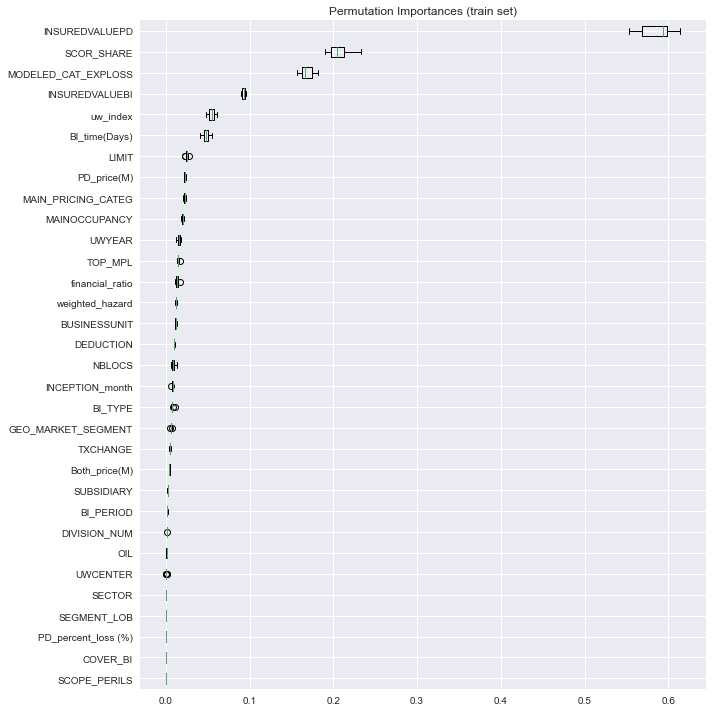

In [30]:
get_feature_importance(clf_gb, X_train_select, y_train)

# <font color='darkorange'>Model 2.2 - XGBoost Regressor(With the chosen features) </font>

#### Training

In [31]:
xg_regressor = XGBRegressor(n_estimators=5000,max_depth=5,learning_rate=0.05)
clf_xg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor' , xg_regressor)])
get_cv_rmse(clf_xg, X_train_select, y_train)

RMSE: 158787.1516 +/- 17725.4315


#### Testing

In [32]:
get_test_rmse(clf_xg, X_train_select, y_train, X_test_select, y_test)

R square Accuracy:  0.7497620789356865
Mean Absolute Error Accuracy:  65069.17848847641
Root Mean Squared Error Accuracy:  166004.7737802232


#### Feature importance

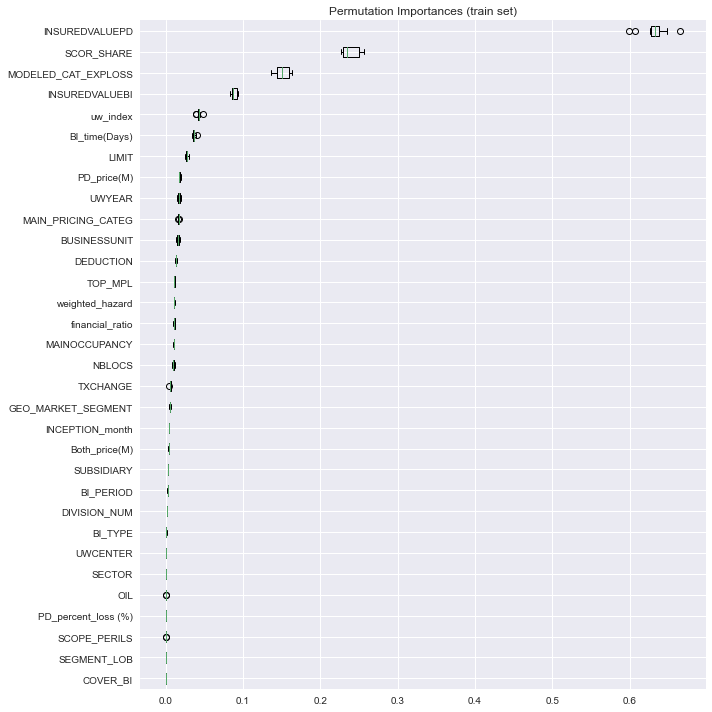

In [33]:
get_feature_importance(clf_xg, X_train_select, y_train)

# <font color='darkorange'>Model 2.3 - LightGBM Regressor(With the chosen features) </font>

#### Training

In [34]:
lgbm_regressor=lgb.LGBMRegressor(feature_fraction=0.8, max_bin=100, max_depth=-1, min_data_in_leaf=5, num_leaves=128)
clf_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor' , lgbm_regressor)])

get_cv_rmse(clf_lgbm, X_train_select, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min

#### Testing

In [35]:
get_test_rmse(clf_lgbm, X_train_select, y_train, X_test_select, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
R square Accuracy:  0.7338363821061528
Mean Absolute Error Accuracy:  66309.23494197412
Root Mean Squared Error Accuracy:  171205.7557454253


#### Feature importance

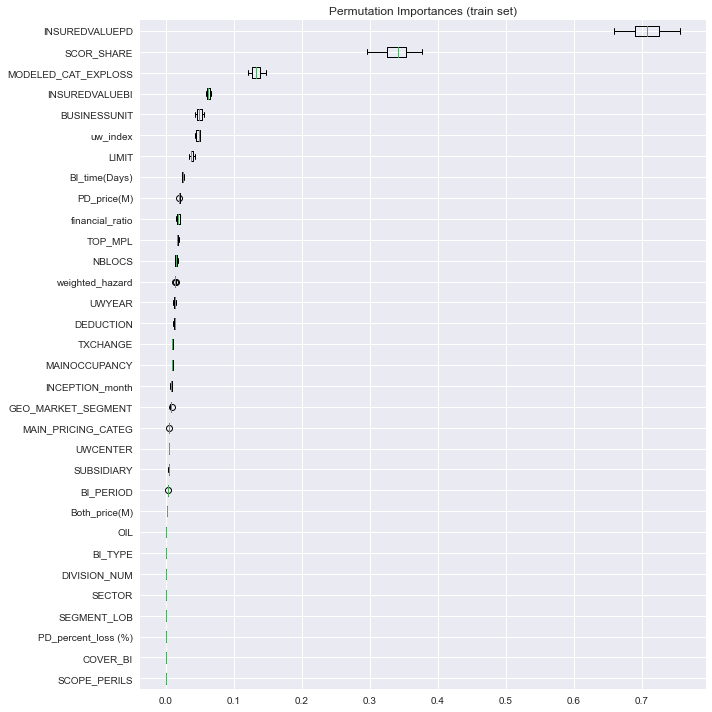

In [36]:
get_feature_importance(clf_lgbm, X_train_select, y_train)

# <font color='darkorange'>Model Comparison </font>

#### Models with all features

| Regressor | Cross-validation RMSE on train set | RMSE on test set | R-squared accuracy on test set| MAE on test set|
| :-: | :-: | :-: | :-: | :-: |
| Gradient Boosting | 160990.27 $\pm$ 13719.80 | 162455.51 | 0.76 | 63816.55 |
| XGBoost | 153410.22 $\pm$ 16199.65 | 160050.03 | 0.77 | 61541.07 |
| LightGBM | 154105.90 $\pm$ 16377.62 | 169139.19 | 0.74 | 64152.35 |


#### Models with chosen features

| Regressor | Cross-validation RMSE on train set | RMSE on test set | R-squared accuracy on test set| MAE on test set|
| :-: | :-: | :-: | :-: | :-: |
| Gradient Boosting | 161795.71 $\pm$ 16290.50 | 167801.57 | 0.74 | 66638.41 |
| XGBoost | 158787.1516 $\pm$ 17725.4315 | 166004.77 | 0.75 | 65069.18 |
| LightGBM | 153179.64 $\pm$ 20032.21 | 171205.76 | 0.73 | 66309.23 |




# <font color='darkorange'>Important Features </font>

From all the analyses before, we could conclude that **INSUREDVALUE_PD**, **XXX_SHARE**, **MODELED_CAT_EXPLOSS**, **INSUREDVALUE_BI**, **Attachment**, **uw_index**, **LIMIT**, **BI_time(Days)**, **PD_price(M)**, **financial_ratio**, **weighted_hasard** and **Deduction** are the most important variables. For some model, the **UWYEAR** and **MAIN_PRICING_CATEG** are also important.

### <font color='darkorange'>Interpretation </font>
**INSUREDVALUE_PD**, **INSUREDVALUE_BI**, **BI_time(Days)**, **PD_price(M)** could imply the insured loss given default (or given accident) and **MODELED_CAT_EXPLOSS** could imply the expected loss due to natural disaster. What's more, **uw_index**, **weighted_hasard** is connected to the risk of natural disaster and probability of accidents in the future. **financial_ratio** and **MAIN_PRICING_CATEG** could be used to show some industry-related or economics-related situations. At last, **XXX_SHARE**, **Attachment**, **LIMIT**, **Deduction** are used to calculated the insured value covered by XXX and the part of responsability of XXX

# <font color='darkorange'>Index (Tuning the hyper parameters of the models) </font>

#### Gradient Boosting

In [ ]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [1, 3, 5, 10, 20],
# }
# gb_reg = GradientBoostingRegressor()
# search = GridSearchCV(gb_reg, param_grid,scoring="neg_mean_squared_error")
# search.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

#### Light GBM

In [ ]:
# lgbm_regressor=lgb.LGBMRegressor(objective='regression',
#                                  boosting='dart',
#                                  #cat_column = X_train.select_dtypes('object').columns.tolist(),
#                                  learning_rate = 0.05,
#                                  num_iterations= 500,
#                                  early_stopping_rounds = 50,
#                                 )
# clf_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('regressor' , lgbm_regressor)])

# param_grid = {
#     'regressor__min_data_in_leaf':[5, 10, 15, 20, 25],
#     'regressor__num_leaves': [32, 64, 128, 256],
#     'regressor__max_depth': [-1, 5, 10, 15],
#     'regressor__max_bin': [50, 100, 200],
#     'regressor__feature_fraction': [0.3, 0.5, 0.8],
# }
# search = GridSearchCV(clf_lgbm, param_grid,scoring="neg_mean_squared_error", n_jobs = 1,verbose=1)
# search.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# regressor__feature_fraction': 0.8, 'regressor__max_bin': 100, 'regressor__max_depth': -1, 'regressor__min_data_in_leaf': 5, 'regressor__num_leaves': 128

# print(search.best_params_)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'regressor__n_estimators': [1000, 2000, 5000],
#     'regressor__max_depth': [3, 5, 10, 20],
#     'regressor__learning_rate': [0.05, 0.1, 0.2]
# }
# search = GridSearchCV(clf_gb, param_grid,scoring="neg_mean_squared_error")
# search.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

#### XGBoost

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'XGBRegressor__n_estimators': [1000, 2000, 5000],
#     'XGBRegressor__max_depth': [3, 5, 10, 20],
#     'XGBRegressor__learning_rate': [0.05, 0.1, 0.2]
# }
# search = GridSearchCV(XGBRegressor(), param_grid,scoring="neg_mean_squared_error")
# search.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

#### Hyperparameter tuning for uw_index

In [ ]:
# def prepare(df, alpha, maxyear):
#     df_new = uw_index(df,alpha,maxyear)
#     train, test = train_test_split(df_new, test_size=0.2)
#     X_train=train.drop(['PREMIUM','FACUL_NUM','UWYEAR'],axis=1)
#     y_train=train[['PREMIUM']]

#     X_test=test.drop(['PREMIUM','FACUL_NUM','UWYEAR'],axis=1)
#     y_test=test[['PREMIUM']]

#     numerical = list(X_train.select_dtypes(include=['float64']).columns.values) 
#     categorical = list(X_train.select_dtypes(exclude=['float64']).columns.values)
#     numeric_transformer = Pipeline(steps=[
#         ('scaler', StandardScaler())])
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numerical),
#             ('cat', categorical_transformer, categorical)])
    
    
#     gb_regressor = XGBRegressor(n_estimators=5000,max_depth=5,learning_rate=0.05)#GradientBoostingRegressor(n_estimators=300, max_depth=5, verbose=1)
#     clf_gb = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('regressor' , gb_regressor)])

#     get_cv_rmse(clf_gb, X_train, y_train)
#     get_test_rmse(clf_gb, X_train, y_train, X_test, y_test)
    
    
# for alpha in [0.3,0.5,0.7]:
#     for maxyear in [3,5,7]:
#         print("alpha: "+str(alpha))
#         print("maxyear: "+str(maxyear))
#         prepare(df,alpha,maxyear)